In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import cv2
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
import math

import open_clip
from f3rm.minimal.interface import NERFinterface
from f3rm.minimal.opt import NERFOpt
from f3rm.features.clip_extract import extract_clip_features, CLIPArgs
from f3rm.minimal.homography import Homography
from f3rm.minimal.utils import run_pca, viz_pca3, compute_similarity_text2vis
from f3rm.minimal.utils import exp_to_homo_T, homo_T_to_exp, se3_distance, cluster_xyz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_path = "outputs/ahgroom_colmap/f3rm/2025-04-14_190026/config.yml"
nerfint = NERFinterface(config_path, device=device)

Using mmap cache: CLIP (18 shards)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/ahgroom_colmap/f3rm/2025-04-14_190026/nerfstudio_models/step-000119999.ckpt

In [3]:
frame1_c2w_44 = NERFOpt.get_init_frame(device=device)
c2w_new_44 = NERFOpt.get_cbev2w_44(device=device)
c2w_new = torch.as_tensor(c2w_new_44[:3, :4]).float().cpu()
FX, FY, WIDTH, HEIGHT = 1150.0, 1150.0, 1920, 1440
K_np = nerfint.get_cam_intrinsics_nodist(fx=FX, fy=FY, width=WIDTH, height=HEIGHT)
K = torch.from_numpy(K_np).to(device, dtype=torch.float32)

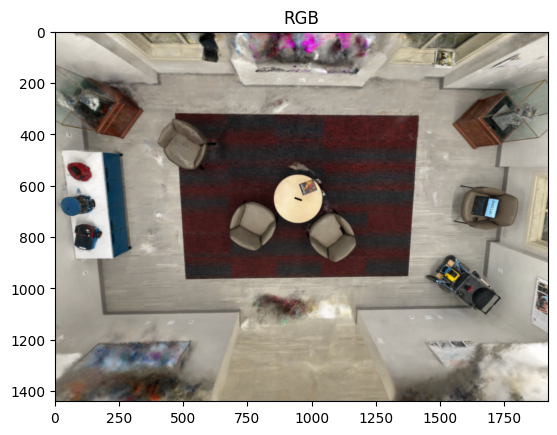

In [4]:
outputs, ray_bundle = nerfint.get_custom_camera_outputs(
    fx=FX,
    fy=FY,
    width=WIDTH,
    height=HEIGHT,
    c2w=c2w_new,
    fars=10.0,
    nears=1.1,
    return_rays=True
)
img = (outputs["rgb"].cpu().numpy() * 255).astype(np.uint8)
plt.imshow(img)
plt.title("RGB")
plt.show()

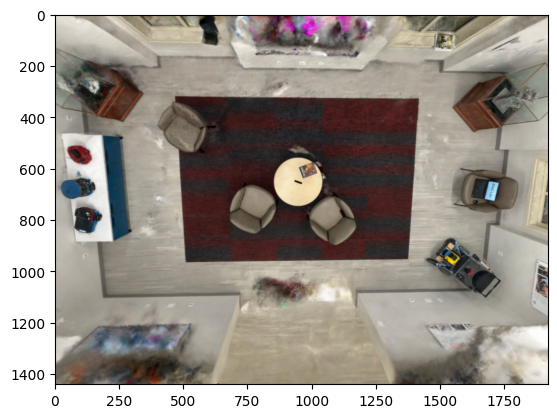

In [5]:
img_copy = img.copy()
bevpcs_coords = NERFOpt.c2w_pose_viz(frame1_c2w_44, c2w_new_44, K, WIDTH, HEIGHT, device=device).cpu().numpy()
cv2.arrowedLine(img_copy, (bevpcs_coords[0][0], bevpcs_coords[0][1]), (bevpcs_coords[1][0], bevpcs_coords[1][1]), (255, 0, 0), 2, tipLength=0.25)
plt.imshow(img_copy)

In [6]:
descriptors = outputs["feature"].cpu()
descriptors.shape

torch.Size([1440, 1920, 768])

In [7]:
model, _, _ = open_clip.create_model_and_transforms(CLIPArgs.model_name, pretrained=CLIPArgs.model_pretrained, device=nerfint.device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=Tru

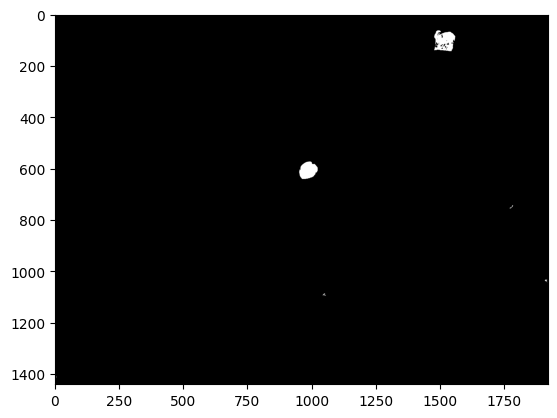

In [8]:
text_queries = ["magazine", "object"]
tokenizer = open_clip.get_tokenizer(CLIPArgs.model_name)
text = tokenizer(text_queries).to(nerfint.device)
text_features = model.encode_text(text)
text_embds = text_features.cpu()
sims = compute_similarity_text2vis(descriptors, text_embds, has_negatives=True, softmax_temp=1.0).squeeze()
# plt.imshow(sims.cpu().numpy(), cmap="turbo")
# plt.show()
magazine_mask = (sims.cpu().numpy() > 0.502)
plt.imshow(magazine_mask, cmap="gray")
plt.show()

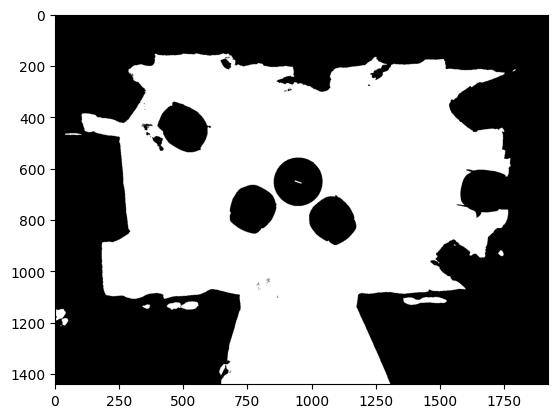

In [9]:
text_queries = ["floor", "object"]
tokenizer = open_clip.get_tokenizer(CLIPArgs.model_name)
text = tokenizer(text_queries).to(nerfint.device)
text_features = model.encode_text(text)
text_embds = text_features.cpu()
sims = compute_similarity_text2vis(descriptors, text_embds, has_negatives=True, softmax_temp=1.0).squeeze()
# plt.imshow(sims.cpu().numpy(), cmap="turbo")
# plt.show()
floor_mask = (sims.cpu().numpy() > 0.502)
plt.imshow(floor_mask, cmap="gray")
plt.show()

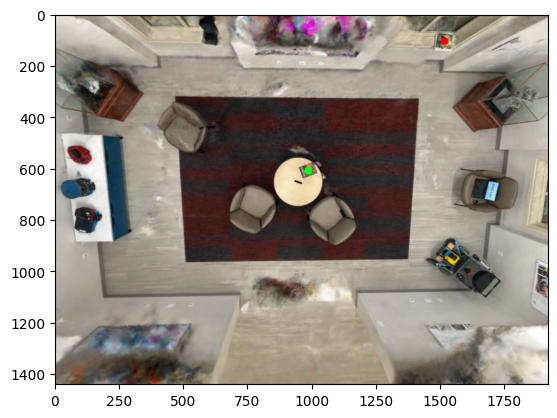

In [10]:
depth = outputs["depth"].squeeze(-1)        # (H,W)
origins = ray_bundle.origins.squeeze(0)      # (H,W,3)
directions = ray_bundle.directions.squeeze(0)   # (H,W,3)
pts_nerf = origins + directions * depth.unsqueeze(-1)
magazine_pts = pts_nerf[magazine_mask].cpu().numpy()
labels, stats = cluster_xyz(magazine_pts, max_auto_K=5)
nerfworld_coords = torch.stack([
    torch.from_numpy(stats[0]['center']).to(device, dtype=torch.float32),
    torch.from_numpy(stats[1]['center']).to(device, dtype=torch.float32)
])
bevpcs_coords = Homography.general_project_A_to_B(nerfworld_coords, torch.linalg.inv(c2w_new_44), device=device)
bevccsnormal_coords = Homography.general_project_A_to_B(bevpcs_coords, NERFinterface.get_nerf_ccs_to_normal_ccs_T(device=device), device=device)
bevpcs_coords, _ = Homography.projectCCStoPCS(bevccsnormal_coords, K, WIDTH, HEIGHT, d=None, mode="none", device=device)

img_copy = img.copy()
cv2.circle(img_copy, (int(bevpcs_coords[0][0]), int(bevpcs_coords[0][1])), 15, (255, 0, 0), -1)
cv2.circle(img_copy, (int(bevpcs_coords[1][0]), int(bevpcs_coords[1][1])), 15, (0, 255, 0), -1)
plt.imshow(img_copy)
plt.show()

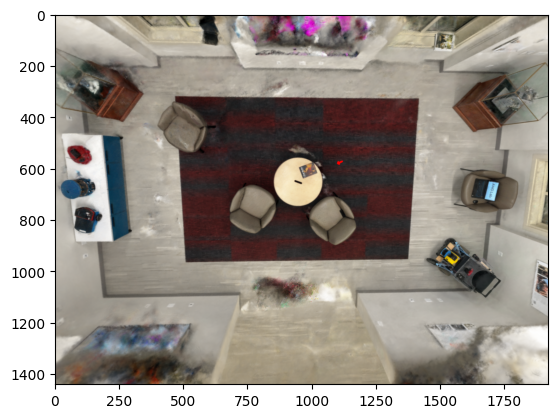

In [11]:
img_copy = img.copy()
bevpcs_coords = NERFOpt.c2w_pose_viz(NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.5, py=1.1, ry=90, device=device), 
                                     c2w_new_44, K, WIDTH, HEIGHT, device=device).cpu().numpy()
cv2.arrowedLine(img_copy, (bevpcs_coords[0][0], bevpcs_coords[0][1]), (bevpcs_coords[1][0], bevpcs_coords[1][1]), (255, 0, 0), 6, tipLength=0.35)
plt.imshow(img_copy)

In [31]:
# fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.385, py=1.091, ry=90, device=device)
fpose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=0.224 , py=1.059, ry=90, device=device)

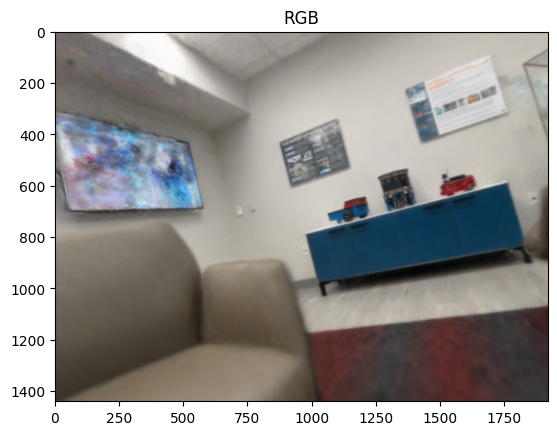

In [32]:
outputs2 = nerfint.get_custom_camera_outputs(
    fx=FX,
    fy=FY,
    width=WIDTH,
    height=HEIGHT,
    c2w=fpose_44[:3, :4],
    # fars=10.0,
    # nears=1.1,
)
img2 = (outputs2["rgb"].cpu().numpy() * 255).astype(np.uint8)
plt.imshow(img2)
plt.title("RGB")
plt.show()

In [14]:
torch.norm(nerfworld_coords[0] - nerfworld_coords[1]).item()

0.7076216340065002

In [17]:
nerfopt_factory = NERFOpt()
obj_fn = nerfopt_factory(device)

Using mmap cache: CLIP (18 shards)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/ahgroom_colmap/f3rm/2025-04-14_190026/nerfstudio_models/step-000119999.ckpt

In [18]:
obj_fn(np.array([0.5, 1.1, 90]))

-1.9977593421936035

In [19]:
obj_fn(np.array([0.385, 1.091, 90]))

inf

In [20]:
obj_fn(np.array([0.519, -27.647, 90.001]))

-1.0

In [29]:
x = torch.from_numpy(np.array([0.385, 1.091, 90])).to(device, dtype=torch.float32)
newc2w_pose_44 = NERFOpt.generate_new_pose(frame1_c2w_44, c2w_new_44, px=x[0].item(), py=x[1].item(), ry=x[2].item(), device=device)

In [30]:
torch.norm(newc2w_pose_44[:3, 3] - nerfworld_coords[1])

tensor(0.0621, device='cuda:0')

In [ ]:
feat_pca = outputs['feature_pca']

In [ ]:
plt.imshow(feat_pca.cpu().numpy(), cmap="turbo")
plt.show()

In [ ]:
outputs["rgb"][(sims.cpu().numpy() > 0.502)].shape

In [ ]:
import open3d as o3d
pcd  = nerfint.pointcloud_from_camera(fx=1150.0, fy=1150.0, width=1920, height=1440, fars=10.0, nears=1.1, c2w=c2w_new, save_feature_pca=True)
o3d.io.write_point_cloud("view2.ply", pcd)
# o3d.visualization.draw_geometries([o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")])

In [ ]:
bev_full = np.asarray(Image.open("temp/bev_room.png").convert("RGB"))
bev_crop_window = bev_full[0:400, 1100:1750, :]
plt.imshow(bev_crop_window)

In [ ]:
def plot_points_on_image(image_path, points, save_path='output.png'):
    if isinstance(image_path, str):
        img = Image.open(image_path).convert('RGB')
    else:
        img = image_path.convert('RGB')
    width, height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Use default colormap
    colors = plt.cm.get_cmap('tab10')

    for i, (x, y) in enumerate(points):
        c1 = patches.Circle((x, y), 6, color=colors(3), fill=True)
        ax.add_patch(c1)
        c2 = patches.Circle((x, y), 16, color=colors(3), fill=False)
        ax.add_patch(c2)

    ax.axis('off')
    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

In [ ]:
rgb_img = outputs["rgb"].cpu().numpy()
rgb_img = (rgb_img * 255).astype(np.uint8)
pil_img = Image.fromarray(rgb_img)
plot_points_on_image(pil_img, points=[(1100, 500), (1000, 500), (1020, 600), (1090, 550)], save_path=None)

In [ ]:
def generate_affordance_map(rgb_img, center_x, center_y, sigma=50):
    """
    Overlays a red affordance heatmap on the input RGB image using a 2D Gaussian centered at (center_x, center_y).
    """
    h, w, _ = rgb_img.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    dist_sq = (xx - center_x) ** 2 + (yy - center_y) ** 2
    gaussian = np.exp(-dist_sq / (2 * sigma ** 2))
    gaussian = (gaussian / np.max(gaussian) * 255).astype(np.uint8)  # Normalize to [0, 255]

    red_overlay = np.zeros_like(rgb_img, dtype=np.uint8)
    red_overlay[..., 0] = gaussian  # Red channel only

    blended = cv2.addWeighted(rgb_img, 1.0, red_overlay, 1.0, 0)
    return blended

In [ ]:
redded = generate_affordance_map(rgb_img, 1350, 300, sigma=120)

In [ ]:
bothredgreen = generate_affordance_map(redded, 1100, 550, sigma=120)

In [ ]:
import open3d as o3d
# o3d.visualization.draw_geometries([o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")])
pcd1 = o3d.io.read_point_cloud("exports/pcd/point_cloud.ply")

In [ ]:
pcd1.points

In [ ]:
import os

file_size = os.path.getsize("exports/pcd/point_cloud.ply")          # ≃1_060_000_000 bytes
header_size = 1024                                      # ≳1 KiB; parse to get exact
bytes_per_vertex = 27                                   # 12 B + 3 B + 12 B

N = (file_size - header_size) // bytes_per_vertex
print(f"≈{N:,} points")                                 # → about 39 260 000 points

In [ ]:
type2bytes = {
    'char':1,'uchar':1,'uint8':1,'float':4,'float32':4,'double':8,'float64':8
}

props = []
with open("exports/pcd/point_cloud.ply","rb") as f:
    while True:
        line = f.readline().decode()
        if line.startswith("element vertex"):
            N = int(line.split()[2])
        if line.startswith("property"):
            _, t, _ = line.split()
            props.append(t)
        if line.strip() == "end_header":
            header_size = f.tell()
            break

bytes_per_vertex = sum(type2bytes[t] for t in props)
computed_size = header_size + N * bytes_per_vertex

print(f"N={N:,}, bytes_per_vertex={bytes_per_vertex}, "
      f"header={header_size} B, total={computed_size/1e9:.3f} GB")
print("On-disk:", os.path.getsize("exports/pcd/point_cloud.ply")/1e9, "GB")
